In [1]:
!pip install CoolProp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive/Thermo-thesis/')

In [4]:
from sCO2Utils import *
from config import Config

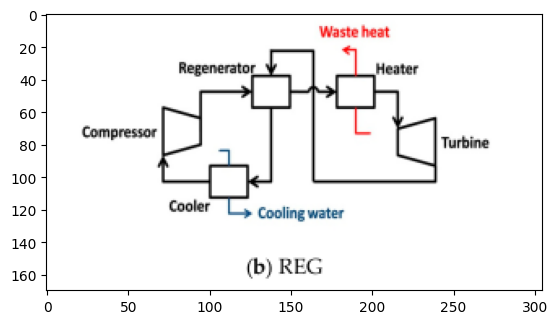

In [5]:
img = plt.imread('REG_setup.png')
plt.imshow(img)

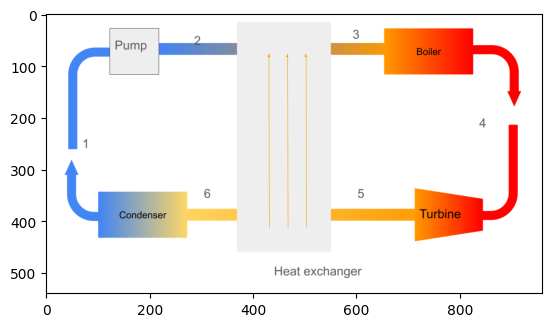

In [6]:
img = plt.imread('Rankine_with_recuperator.png')
plt.imshow(img)

In [7]:
def resolve_REG_cycle(
    P1 : float,
    T1 : float,
    T4 : float,
    pump_isentropic_efficiency : float,
    turbine_isentropic_efficiency : float,
    heat_exchanger_efficiency : float,
    rp : float,
    grading : float
):

  P4 = P1*rp # Changing the pressure ratio
  P2,P3 = P4,P4
  P5,P6 = P1,P1
  # Compute known states
  state1 = ThermodynamicState(p = P1,t = T1); state1.compute_from_p_t()
  state4 = ThermodynamicState(p = P4,t = T4); state4.compute_from_p_t()

  turbine = Turbine(isentropic_efficiency=turbine_isentropic_efficiency,output_pressure=P1)
  pump = Pump(isentropic_efficiency=pump_isentropic_efficiency,output_pressure=P2)

  state2 = pump.resolve_actual_output_state(input_state = state1)
  state5 = turbine.resolve_actual_output_state(input_state = state4)

  heat_exchanger = HeatExchanger(
      stream1_entry_state=state2,
      stream2_entry_state=state5,
      grading = grading,
      efficiency = heat_exchanger_efficiency
  )

  state3, state6 = heat_exchanger.resolve_exit_states()

  qout = state6.h -state1.h
  qin = state4.h - state3.h
  eta_rankine = 1 - qout/qin # Compute Efficiency

  # Compute Backwork ratio
  # Compute Exergy
  # Compute
  return [eta_rankine, [state1,state2,state3,state4,state5,state6]]

In [8]:
# INITIAL CONDITIONS
P1 = Config.rankine_Pmin
T1 = Config.T1
T4 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

In [9]:
rp_min = Config.rankine_rp_min
rp_max = Config.rankine_rp_max
N = 50 # points
M = 10 # points
rp_list = list(np.linspace(rp_min,rp_max,N))
grading_max = 1
grading_array = list(np.linspace(.01,grading_max,M))
REG_efficiency = np.zeros((N,M))

for grad_id, grading in enumerate(list(grading_array)):
  for r_id, rp in enumerate(rp_list):
    REG_efficiency[r_id, grad_id] = resolve_REG_cycle(
        P1 = P1,
        T1 = T1,
        T4 = T4,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp,
        grading = grading
    )[0]

In [10]:
fig = go.Figure(data=[go.Surface(z=REG_efficiency.copy(), y = rp_list, x = grading_array)])
fig.update_layout(title='Rankine efficiency vs pressure ration and Heat Exchanger grading')
fig.update_scenes(zaxis_title_text='Efficiency',
                  yaxis_title_text = 'Pressure ratio')
fig.show()

### SANITY CHECK
Check for maximum efficiency when grading is close to 0, meaning the heat exchanger is very poor.
The design turns into the ideal Simple Rankine design, which we know has a maximum efficiency of 14.32%

In [11]:
rp_max = rp_list[np.argwhere(REG_efficiency[:,0] == REG_efficiency[:,0].max())[0][0]]
print(f'Max efficiency is {"{:.2f}".format(REG_efficiency[:,0].max()*100)}% for rp = {rp_max}');

Max efficiency is 14.32% for rp = 4.189183673469388


This proves that the heat exchanger simulation works well in the low grading regime

### Let us look at the results for varying grading

In [12]:
rp_best, grading_best = np.where(REG_efficiency == REG_efficiency.max())
rp_best = rp_list[rp_best[0]]
grading_best = grading_array[grading_best[0]]
print(f'The maximum of efficiency of {"{:.2f}".format(REG_efficiency.max()*100)} % is reached for rp = {rp_best} and grading {grading_best}')
print(f'The maximum of efficiency of {"{:.2f}".format(REG_efficiency.max()*100)} % is reached for p = {rp_best*5} MPa and grading {grading_best}')

The maximum of efficiency of 15.05 % is reached for rp = 3.241428571428572 and grading 1.0
The maximum of efficiency of 15.05 % is reached for p = 16.20714285714286 MPa and grading 1.0


### Two things to notice
1. We have a maximum efficiency of 1% higher than the simple Rankine
2. The maximum rp varies with the gradient

In [13]:
# Pick the best performing pressure ratio
rp = rp_best
_eta, states_list = resolve_REG_cycle(
      P1 = P1,
      T1 = T1,
      T4 = 273+100,
      pump_isentropic_efficiency=pump_isentropic_efficiency,
      turbine_isentropic_efficiency=turbine_isentropic_efficiency,
      heat_exchanger_efficiency= heat_exchanger_efficiency,
      rp = rp_best,
      grading = grading_best
  )

In [14]:
show_states_table(states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1   7.190000e+06       303.000000        302.929951          1.338232
2   2.330587e+07       339.508178        332.119155          1.355492
3   2.330587e+07       318.101744        284.424273          1.210440
4   2.330587e+07       373.000000        410.117176          1.574624
5   7.190000e+06       303.556950        379.894410          1.592203
6   7.190000e+06       313.144358        427.589293          1.747480


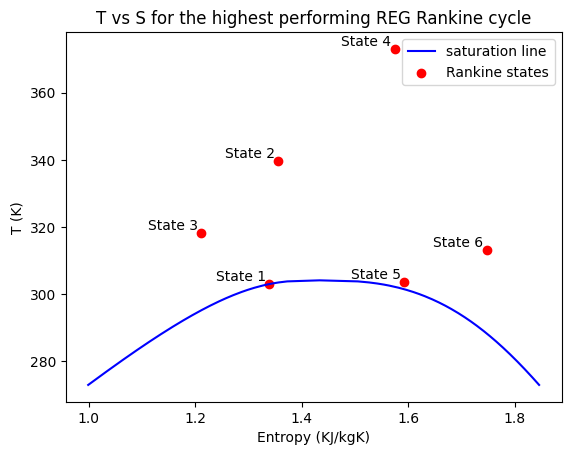

In [15]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing REG Rankine cycle')
rankine_state_xpoints = [state.s for state in states_list]
rankine_state_ypoints = [state.t for state in states_list]
ax.text(rankine_state_xpoints[0] - .1, rankine_state_ypoints[0] + 1,'State 1')
ax.text(rankine_state_xpoints[1] - .1, rankine_state_ypoints[1] + 1,'State 2')
ax.text(rankine_state_xpoints[2] - .1, rankine_state_ypoints[2] + 1,'State 3')
ax.text(rankine_state_xpoints[3] - .1, rankine_state_ypoints[3] + 1,'State 4')
ax.text(rankine_state_xpoints[4] - .1, rankine_state_ypoints[4] + 1,'State 5')
ax.text(rankine_state_xpoints[5] - .1, rankine_state_ypoints[5] + 1,'State 6')
ax.scatter(rankine_state_xpoints, rankine_state_ypoints, color = 'red', label = 'Rankine states')
ax.legend()

# LET US COMPARE Rankine WITH A BRAYTON CYCLE

This means we start at an P_min > 7.38 MPa (let us choose 7.5MPa), but we still keep the maximum pressure constraints.

This means our max rp is 35/7.5 = 4.67, and we start from rp = 1.5

In [16]:
# INITIAL CONDITIONS for BRAYTON
P1 = Config.brayton_Pmin
T1 = Config.T1
T4 = Config.Tmax
pump_isentropic_efficiency = Config.pump_isentropic_efficiency
turbine_isentropic_efficiency = Config.turbine_isentropic_efficiency
heat_exchanger_efficiency = Config.heat_exchanger_efficiency

# Note
We use the same code for computing efficiency as the only parameters that we change in order to turn a Brayton to a Rankine is the pressure range

In [17]:
rp_min = Config.brayton_rp_min
rp_max = Config.brayton_rp_max
N = 10 # points
M = 10 # points
rp_list = list(np.linspace(rp_min,rp_max,N))
grading_max = 1
grading_array = list(np.linspace(.01,grading_max,M))
REG_efficiency = np.zeros((N,M))

for grad_id, grading in enumerate(list(grading_array)):
  for r_id, rp in enumerate(rp_list):
    REG_efficiency[r_id, grad_id] = resolve_REG_cycle(
        P1 = P1,
        T1 = T1,
        T4 = T4,
        pump_isentropic_efficiency=pump_isentropic_efficiency,
        turbine_isentropic_efficiency=turbine_isentropic_efficiency,
        heat_exchanger_efficiency= heat_exchanger_efficiency,
        rp = rp,
        grading = grading
    )[0]

In [18]:
fig = go.Figure(data=[go.Surface(z=REG_efficiency.copy(), y = rp_list, x = grading_array)])
fig.update_layout(title='Brayton efficiency vs pressure ration and Heat Exchanger grading')
fig.update_scenes(zaxis_title_text='Efficiency ',
                  yaxis_title_text='Pressure ratio ')
fig.show()

In [19]:
rp_best, grading_best = np.where(REG_efficiency == REG_efficiency.max())
rp_best = rp_list[rp_best[0]]
grading_best = grading_array[grading_best[0]]
print(f'The maximum of efficiency of {"{:.2f}".format(REG_efficiency.max()*100)} % is reached for rp = {rp_best} and grading {grading_best}')
print(f'The maximum of efficiency of {"{:.2f}".format(REG_efficiency.max()*100)} % is reached for p = {rp_best * 7.5} MPa and grading {grading_best}')

The maximum of efficiency of 14.74 % is reached for rp = 3.261111111111111 and grading 1.0
The maximum of efficiency of 14.74 % is reached for p = 24.458333333333332 MPa and grading 1.0


We notice something surprising

Brayton benefits a lot more from a well performing heat exchanger.

The maximum efficiency for a poor heat exchanger is 6.18% while for a good one is 10.31%, competing with the best Rankine cycle

In [20]:
# Pick the best performing pressure ratio
rp = rp_best
_eta, brayton_states_list = resolve_REG_cycle(
      P1 = P1,
      T1 = T1,
      T4 = 273+100,
      pump_isentropic_efficiency=pump_isentropic_efficiency,
      turbine_isentropic_efficiency=turbine_isentropic_efficiency,
      heat_exchanger_efficiency= heat_exchanger_efficiency,
      rp = rp_best,
      grading = grading_best
  )

In [21]:
show_states_table(brayton_states_list)

   pressure (Pa)  temperature (K)  enthalpy (KJ/kg)  entropy (KJ/kgK)
1   7.500000e+06       303.000000        290.458448          1.295477
2   2.445833e+07       334.696295        319.234643          1.312740
3   2.445833e+07       316.349484        279.698559          1.191283
4   2.445833e+07       373.000000        405.882594          1.557837
5   7.500000e+06       305.733799        375.716232          1.575257
6   7.500000e+06       311.965718        415.252315          1.703561


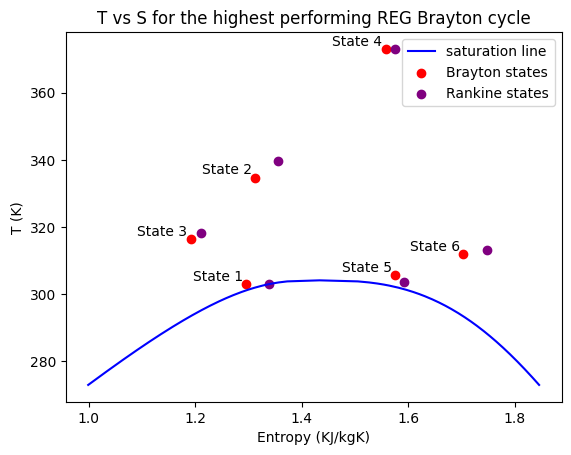

In [22]:
fig, ax = plot_tvss_phase_transition_region(273, 'T vs S for the highest performing REG Brayton cycle')
brayton_state_xpoints = [state.s for state in brayton_states_list]
brayton_state_ypoints = [state.t for state in brayton_states_list]
ax.text(brayton_state_xpoints[0] - .1, brayton_state_ypoints[0] + 1,'State 1')
ax.text(brayton_state_xpoints[1] - .1, brayton_state_ypoints[1] + 1,'State 2')
ax.text(brayton_state_xpoints[2] - .1, brayton_state_ypoints[2] + 1,'State 3')
ax.text(brayton_state_xpoints[3] - .1, brayton_state_ypoints[3] + 1,'State 4')
ax.text(brayton_state_xpoints[4] - .1, brayton_state_ypoints[4] + 1,'State 5')
ax.text(brayton_state_xpoints[5] - .1, brayton_state_ypoints[5] + 1,'State 6')
ax.scatter(brayton_state_xpoints, brayton_state_ypoints, color = 'red', label = 'Brayton states')
ax.scatter(rankine_state_xpoints, rankine_state_ypoints, color = 'purple', label = 'Rankine states')
ax.legend()